In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import pandas_ta as ta
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state, test_size
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format, apply_date_to_week
from utils.plotting import *
from src.src import *
from src.models import ExpandingPredictionOLS, SKLearnWrapOLS

In [4]:
# Load data
model_type = "ols"
tinterval = 'daily'

year_start = 2012
year_end = 2021
year_spread = f'years{year_end}_{year_start}'

variables = 'FF_TS_VX' #'FF' # 'FF_TS_VX'

name = f'{tinterval}_{variables}_{year_spread}'

df_w = load_data(file_name=f"df_{name}.csv", file_path=OUT_DATA_DIR)
data_dict = load_data(file_name=f"dict_{name}.pkl", file_path=OUT_DATA_DIR)

In [5]:
# update dict with model specific information
data_dict["model_features"].update(datetime_ind=dict(zip(df_w.index, df_w.date)))

data_dict["model_metrics"].update(model_type=model_type)
data_dict["model_metrics"].update(variables=variables)
data_dict["model_metrics"].update(tinterval=tinterval)
data_dict["model_metrics"].update(model_name=f"{model_type}_{name}_{data_dict['model_features']['predicted']}")

# data selection

In [6]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
    'vixo',
     'ff_M_RF',
     'ff_SMB',
     'ff_HML',
     'ff_RMW',
     'ff_CMA',
    'macd',
    'macdh',
    'williamsr',
     'termspread',
     # 'pc_ratio',
     'sp_close',
     'sp_close_lag1',
     'sp_close_lag2',
     'sp_close_lag3',
     'sp_close_lag4',
     'sp_close_lag5',
     'sp_close_lag6',
     'sp_close_lag7',
     'sp_close_lag8',
     'sp_close_lag9',
     # 'sp_close_lag10',
     # 'sp_close_lag11',
     # 'sp_close_lag12',
     # 'sp_close_lag13',
     # 'sp_close_lag14',
     # 'sp_close_lag15'
]

categorical = [    
     # 'weekday',
     # 'weekday_0',
     # 'weekday_1',
     # 'weekday_2',
     # 'weekday_3',
     # 'weekday_4'
]

## categorical features
if len(categorical) > 0:
    cols = cols + categorical
    data_dict["model_features"]["categorical"] = categorical

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

In [7]:
df_ws = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

# TTS

In [8]:
df_train = df_ws.copy()

In [9]:
X_train, X_test, y_train, y_test = tts_data(df_train,
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            random_split=False,
                                            test_size=test_size,
                                            add_const=False)

# Sesonality


 Len of complete weeks in X_train: 1660


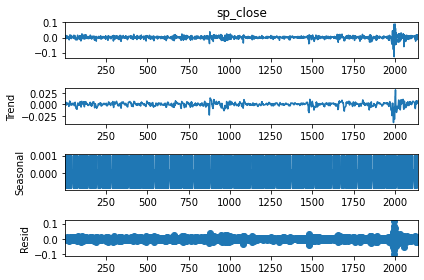

In [10]:
# create sub dataframe of X_train
X_train_sea = X_train.copy()

# insert datetime information
X_train_sea["date"] = pd.Series(X_train_sea.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x]).values
X_train_sea["weekday"] = is_day(X_train_sea.date)
X_train_sea["week"] = X_train_sea.date.apply(lambda x: apply_date_to_week(x))

# create seasonality object
sd = SeasonalTrend(X_train_sea, 'sp_close', 'week', 'weekday', 5, show_fig=True)       
sd.split_time_series()

 # map sesonality to data
if tinterval == 'daily': 
    data_dict["model_features"]["weekday_seasonality"] = sd.dict_map_sasonal
    
    _ = pd.Series(X_test.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x])
    X_test["seasonal"] = is_day(_).map(data_dict["model_features"]["weekday_seasonality"]).values

    _ = pd.Series(X_train.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x])
    X_train["seasonal"] = is_day(_).map(data_dict["model_features"]["weekday_seasonality"]).values

    cols.append("seasonal")

# Corr

In [11]:
# merging X, y for analysis purposes
X_train = pd.concat([X_train, y_train], axis=1)

Corr matrix

In [12]:
## ORTHOGONALISE
X_train = orthogonalise_vars(X_train, X="sp_close", y="ff_M_RF", show_fig=False)
X_train = orthogonalise_vars(X_train, X="vixo", y="macd", show_fig=False)
X_train = orthogonalise_vars(X_train, X="williamsr", y="macd", show_fig=False)

,VIF,corr_sp_close_lead1
sp_close,2.483114,-0.182111
sp_close_lag7,1.636756,-0.147710
sp_close_lag5,2.050482,-0.132321
sp_close_lag3,2.537227,-0.071734
sp_close_lag9,1.325460,-0.053621
ff_HML,1.608566,-0.032570
williamsr,7.308426,-0.030612
seasonal,1.028778,-0.026386
sp_close_lag2,2.508313,-0.012414
macd,1.374522,-0.010950


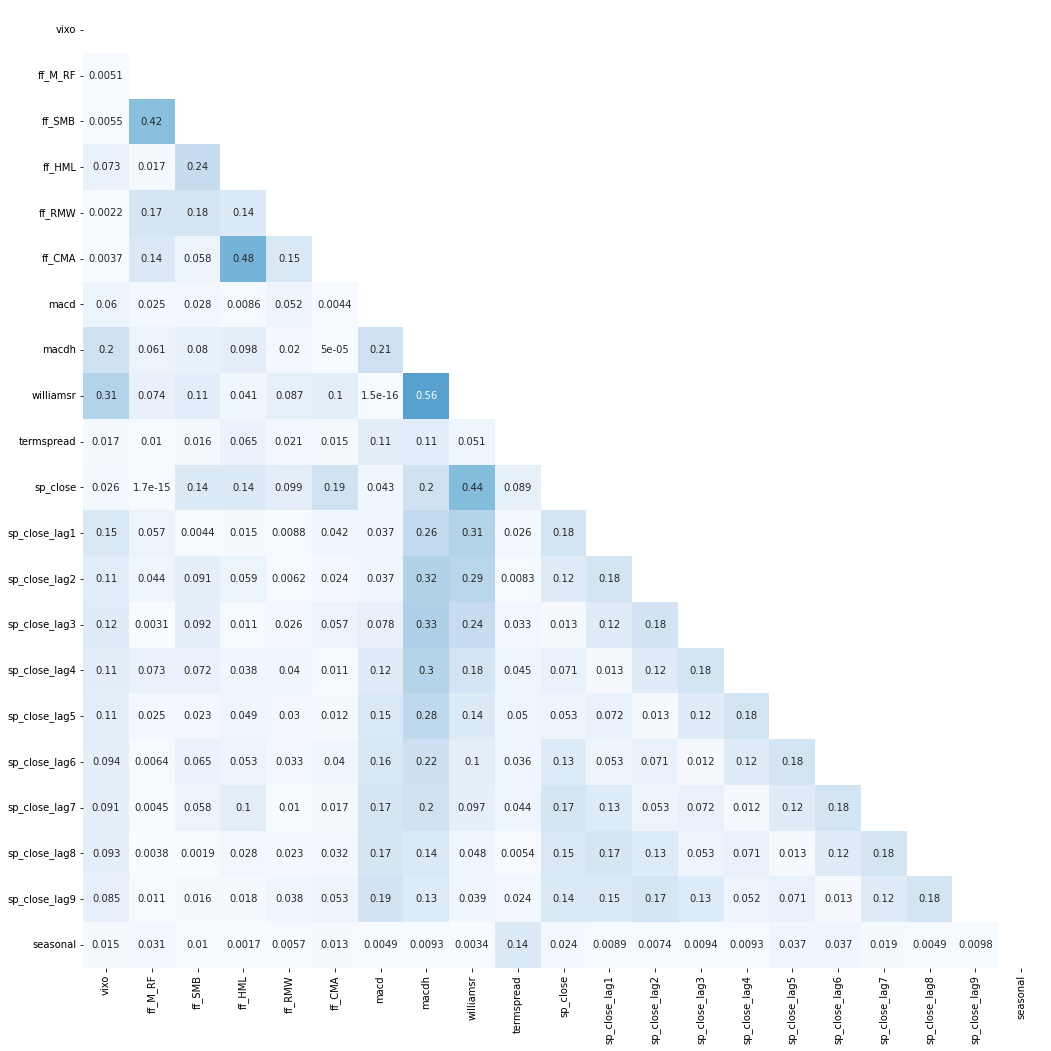

In [13]:
# only rely on correlation not vif
fig_corr = corr_heatmap(X_train, 
             cols,
             size_factor=.7,
             show_fig=True)

get_variance_inflation_factor(
                              X_train,
                              # pd.concat([X_test, y_test], axis=1),
                              cols,
                              col_pred=data_dict["model_features"]["predicted"])

# Model

In [14]:
# dropping y col from X_train
X_train.drop(data_dict["model_features"]['predicted'], axis=1, inplace=True)
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

In [15]:
model_wrap = ExpandingPredictionOLS(SKLearnWrapOLS(sm.OLS),
                    X_train,
                    y_train,
                    X_test,
                    y_test)

# Out of sample eval

In [16]:
mval = ModelValidation(
            X_train=X_train,
            y_train=y_train,
            X_validate=X_test,
            y_validate=y_test,
            model=model_wrap,
            print_results=True)

In [17]:
mval.model_wrapper.model.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sp_close_lead1   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     11.95
Date:                Tue, 05 Apr 2022   Prob (F-statistic):           5.25e-39
Time:                        18:54:32   Log-Likelihood:                 7567.6
No. Observations:                2376   AIC:                        -1.509e+04
Df Residuals:                    2354   BIC:                        -1.496e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
vixo              0.0010      0.001      1.256      0.209      -0.001       0.002
ff_M_RF           0.0383      0.069      0.557      0.577      -0.096       0.173
ff_SMB            0.1138      0.039      2.916      0.004       0.037       0.190
ff_HML           -0.0169      0.036     -0.467      0.640      -0.088       0.054
ff_RMW            0.0270      0.057      0.475      0.635      -0.084       0.138
ff_CMA           -0.0433      0.075     -0.580      0.562      -0.189       0.103
macd          -4.955e-06   1.09e-05     -0.453      0.651   -2.64e-05    1.65e-05
macdh             0.0002   5.88e-05      3.149      0.002    6.99e-05       0.000
williamsr      1.883e-05    1.2e-05      1.567      0.117   -4.74e-06    4.24e-05
termspread        0.0003      0.003      0.123      0.902      -0.005       0.006
sp_close         -0.1912      0.031     -6.085      0.000      -0.253      -0.130
sp_close_lag1    -0.0066      0.033     -0.200      0.842      -0.072       0.059
sp_close_lag2    -0.0599      0.033     -1.811      0.070      -0.125       0.005
sp_close_lag3    -0.1431      0.033     -4.280      0.000      -0.209      -0.078
sp_close_lag4    -0.0671      0.032     -2.114      0.035      -0.129      -0.005
sp_close_lag5    -0.1388      0.030     -4.621      0.000      -0.198      -0.080
sp_close_lag6     0.0689      0.028      2.427      0.015       0.013       0.125
sp_close_lag7    -0.1115      0.027     -4.207      0.000      -0.164      -0.060
sp_close_lag8     0.0457      0.026      1.786      0.074      -0.004       0.096
sp_close_lag9    -0.0368      0.023     -1.573      0.116      -0.083       0.009
seasonal         -0.2804      0.340     -0.824      0.410      -0.947       0.387
intercept        -0.0012      0.002     -0.526      0.599      -0.006       0.003
==============================================================================
Omnibus:                      913.050   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16836.338
Skew:                          -1.337   Prob(JB):                         0.00
Kurtosis:                      15.764   Cond. No.                     7.69e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
mval.model_wrapper.model.trained_model.bic

-14964.14539855031

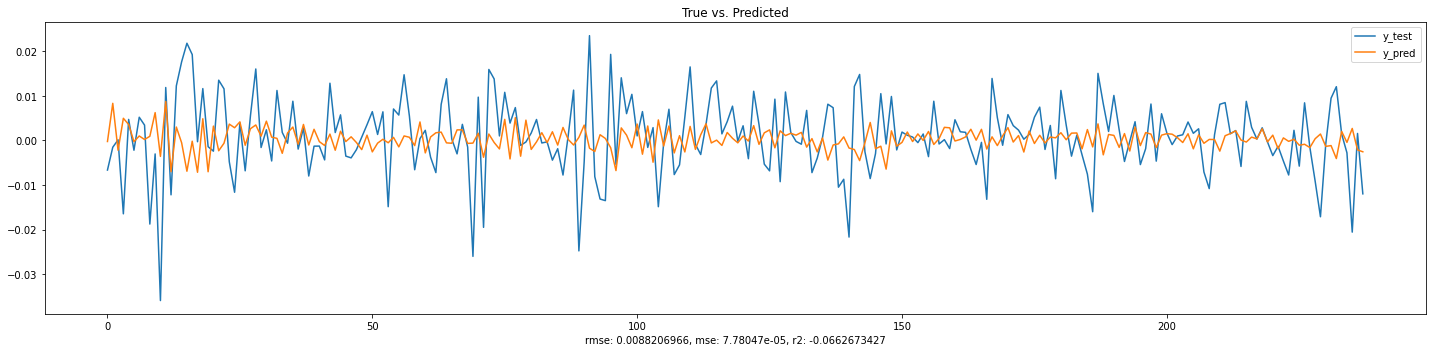

Validation Scores
root mean squared error: 0.0088206966
mean squared error: 7.78047e-05
mean absolute error: 0.0065777924
R2: -0.0662673427


In [19]:
fig_true_vs_fit = mval.get_model_performance()

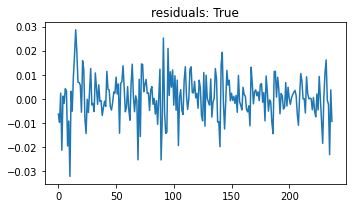

Stationarity Test Results
P-Values: 3.432518966790005e-17
Test-stats: -9.897215014499634
Time series is stationary: True
Number of lags used: 2




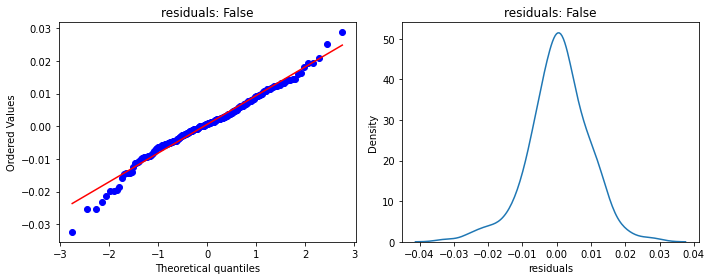

Normality Test Results
P-Values: 0.0017698337996811047
Test-stats: 12.673739270580779
Series is normally distributed: False


HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


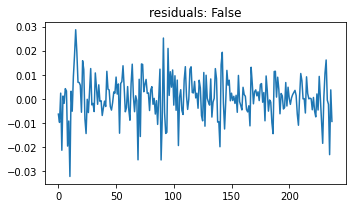

Test for Heteroskedasticity
Test p-value: 0.4695172020616232
Heteroskedasticity is present: False


TTest one sample for mean: 0
Test statistics: 1.0014376440253354
Test pvalue: 0.31763663239220985
Population mean is equal to 0: False


Durbin watson test for first oder autocorrelation
Test statistics: 1.5 < 1.807 < 2.5
First order autocorrlation is not present: : True


In [20]:
stat, norm, hetero, d_watson, zero_mean = mval.analyse_resids()

In [25]:
# update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)
data_dict["model_metrics"].update(d_watson_aucorr=d_watson)
data_dict["model_metrics"].update(aic=mval.model_wrapper.model.trained_model.aic)
data_dict["model_metrics"].update(bic=mval.model_wrapper.model.trained_model.bic)

# model performance
data_dict["model_metrics"].update(rmse=mval.rmse)
data_dict["model_metrics"].update(mse=mval.mse)
data_dict["model_metrics"].update(mae=mval.mae)
data_dict["model_metrics"].update(r2=mval.r2)
data_dict["model_metrics"].update(residuals=mval.resid_inv)

# Save model

In [26]:
save_model(model=mval.model_wrapper, 
           df_train=df_train,
           data_dict=data_dict,
           plt_figures=[fig_true_vs_fit, fig_corr], 
           fig_titles=['fig_truefit', 'fig_corr'],
           model_dir=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-04-05_ols_daily_FF_TS_VX_years2021_2012_sp_close_lead1"? (y/n)


 y
DIR EXISTS: DO YOU WANT TO REPLACE IT? (y/n) n


KeyError: 'No output directory specified'